In [3]:
import pymc as pm
import numpy as np
pm.__version__
np.set_printoptions(precision=3, suppress=True)

In [33]:
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1, 
                                usecols=[1,2], 
                                missing_values="NA", 
                                delimiter=',')
print(challenger_data.shape)

(23, 2)


In [49]:
challenger_data = challenger_data[~np.isnan(challenger_data[:,1])]

In [50]:
# clean outlier data
challenger_data[:,0:1][challenger_data[:,0:1] > 1] = 1

Text(0.5, 1.0, 'Temp (F), O-ring failure?')

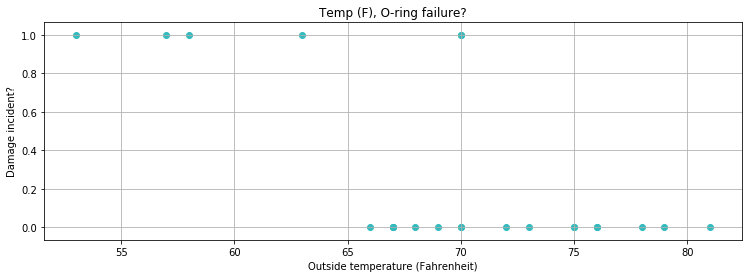

In [51]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12.5,4))
colors = ['#34BABD', '#A60628']
plt.scatter(challenger_data[:,1], challenger_data[:,0], color=colors[0])
plt.grid(True)
plt.xlabel('Outside temperature (Fahrenheit)')
plt.ylabel('Damage incident?')
plt.title('Temp (F), O-ring failure?')

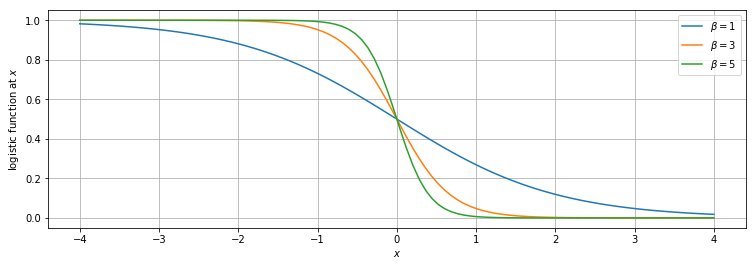

In [69]:
fig = plt.figure(figsize=(12.5,4))

def logistic(x, beta, alpha=0):
    return 1.0/(1.0 + np.exp(beta * x + alpha))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r'$\beta = 1$')
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, 5), label=r"$\beta = 5$")
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'logistic function at $x$')
plt.legend()


<Figure size 900x288 with 0 Axes>

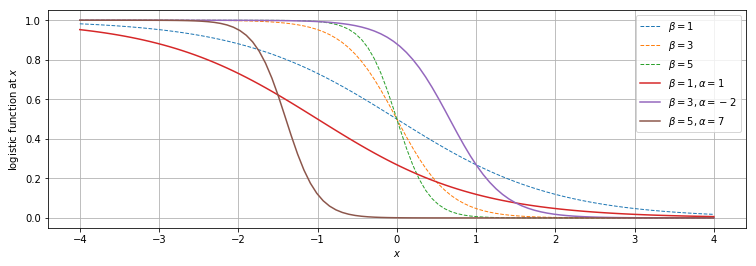

In [75]:
fig = plt.figure(figsize=(12.5,4))
plt.plot(x, logistic(x, 1), label=r'$\beta = 1$', lw=1, ls='--')
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", lw=1, ls='--')
plt.plot(x, logistic(x, 5), label=r"$\beta = 5$", lw=1, ls='--')

plt.plot(x, logistic(x, 1, 1), label=r'$\beta = 1, \alpha = 1$')
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2 $")
plt.plot(x, logistic(x, 5, 7), label=r"$\beta = 5, \alpha = 7$")

plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'logistic function at $x$')
plt.legend()


In [76]:
import pymc as pm

In [83]:
temperature = challenger_data[:,1:2].ravel()
D = challenger_data[:,0:1].ravel()

beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0/(1. + np.exp(beta * t + alpha))

observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)
model = pm.Model([observed, beta, alpha])

In [115]:
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000,2)

 [-----------------100%-----------------] 120000 of 120000 complete in 9.9 sec

In [116]:
alpha_samples = mcmc.trace('alpha')[:, None]
beta_samples = mcmc.trace('beta')[:, None]

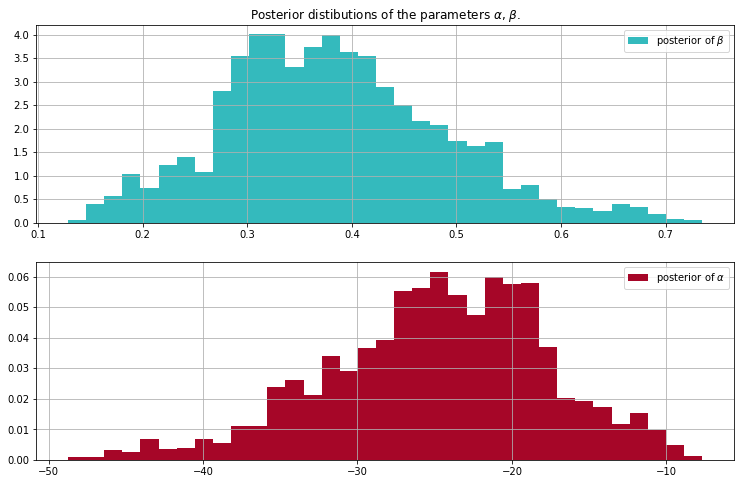

In [117]:
fig = plt.figure(figsize=(12.5, 8))
plt.subplot(211)
plt.title(r'Posterior distibutions of the parameters $\alpha$, $\beta$.')
plt.hist(beta_samples, bins=35, normed=True, color=colors[0], label=r'posterior of $\beta$')
plt.legend()
plt.grid(True)
plt.subplot(212)
plt.hist(alpha_samples, bins=35, normed=True, color=colors[1], label=r'posterior of $\alpha$')
plt.legend()
plt.grid(True)

In [137]:
# next we look at an expected probability for a specific value of the temperature
t = np.linspace(temperature.min()-5, temperature.max()+5, 50)[:,None]
p_t = logistic(t.T, beta_samples, alpha_samples)
mean_prob_t = p_t.mean(axis=0)
print(mean_prob_t)

[0.991 0.989 0.987 0.985 0.981 0.978 0.973 0.967 0.96  0.951 0.94  0.927
 0.91  0.89  0.866 0.837 0.802 0.76  0.713 0.659 0.599 0.536 0.47  0.404
 0.341 0.283 0.231 0.186 0.149 0.119 0.094 0.074 0.059 0.047 0.037 0.029
 0.023 0.019 0.015 0.012 0.01  0.008 0.006 0.005 0.004 0.003 0.003 0.002
 0.002 0.002]


Text(0.5, 1.0, 'Posterior expected value of the probability of defect, including two realizations')

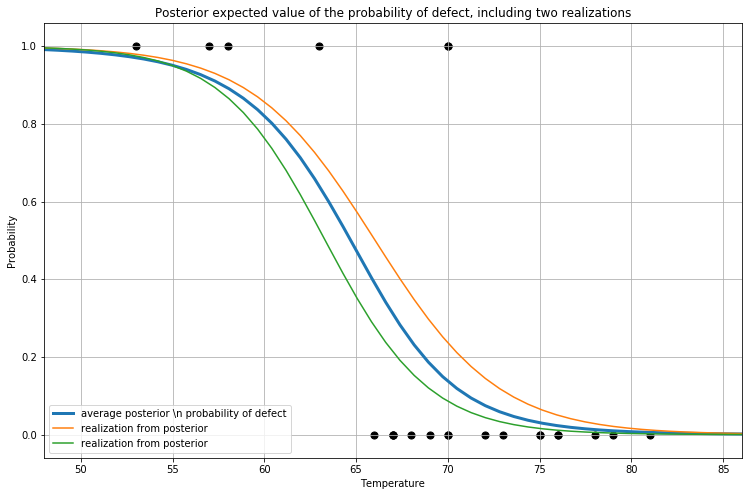

In [146]:
fig = plt.figure(figsize=(12.5, 8))
plt.plot(t, mean_prob_t, label=r'average posterior \n probability of defect', lw=3)
plt.plot(t, p_t[0, :], label=r'realization from posterior')
plt.plot(t, p_t[-2, :], label=r'realization from posterior')
plt.scatter(temperature, D, color='k', s=50)
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'logistic function at $x$')
plt.legend(loc="lower left")
plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.xlim(t.min(), t.max())
plt.title('Posterior expected value of the probability of defect, including two realizations')

In [148]:
from scipy.stats.mstats import mquantiles

In [149]:
qs = mquantiles(p_t, [0.025, 0.975], axis=0)

Text(0.5, 1.0, 'Posterior expected value of the probability of defect, including two realizations')

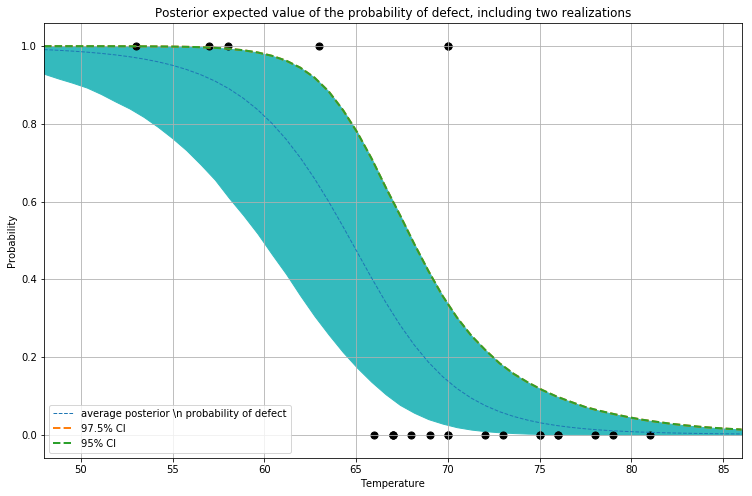

In [157]:
fig = plt.figure(figsize=(12.5, 8))
plt.plot(t, mean_prob_t, label=r'average posterior \n probability of defect', lw=1, ls="--")
plt.fill_between(t[:,0], *qs, color=colors[0])
plt.plot(t[:,0], qs[1], label=r'97.5% CI', lw=2, ls="--")
plt.plot(t[:,0], qs[1], label=r'95% CI', lw=2, ls="--")
plt.scatter(temperature, D, color='k', s=50)
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'logistic function at $x$')
plt.legend(loc="lower left")
plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.xlim(t.min(), t.max())
plt.title('Posterior expected value of the probability of defect, including two realizations')